# Amazon Reviews

[Readme](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) \
[Index](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt)


## Column Descriptions

* marketplace       - 2 letter country code of the marketplace where the review was written.
* customer_id       - Random identifier that can be used to aggregate reviews written by a single author.
* review_id         - The unique ID of the review.
* product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
* product_parent    - Random identifier that can be used to aggregate reviews for the same product.
* product_title     - Title of the product.
* product_category  - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).
* star_rating       - The 1-5 star rating of the review.
* helpful_votes     - Number of helpful votes.
* total_votes       - Number of total votes the review received.
* vine              - Review was written as part of the Vine program.
* verified_purchase - The review is on a verified purchase.
* review_headline   - The title of the review.
* review_body       - The review text.
* review_date       - The date the review was written.


In [1]:
import pandas as pd
import gzip
import os
import numpy as np

from typing import Dict, Optional, List, Union

### Download, Parse and Load Dataset

In [2]:
def parse_gz(path: str):
    '''
    Open GZ file and decode bytes to strings
    inputs:
        path: string, path to the .gz file
    '''
    g = gzip.open(path, 'rb')
    for l in g:
        l = l.decode("utf-8") 
        yield l
        
def read_reviews(path: str):
    '''
    Read Amazon's product reviews file and return a pandas DataFrame
    inputs:
        path: string, path to the .tsv.gz file
    '''
    data = []
    for i, line in enumerate(parse_gz(path)):
        
        line = line.split('\t') # separate the tab separated line
        line[-1] = line[-1].strip() # remove trailing new lines
        data.append(line)
        
    columns = data.pop(0)
    return pd.DataFrame.from_records(data, columns=columns)

def download_reviews(url: str, location: str, filename: Optional[str] = 'reviews.gz'):
    '''
    Downloads an S3 tsv.gz file and unzips it locally
    inputs:
        ur:
        location:
        filename:
    '''
    
    # create new directory to store the product reviews
    try:
        os.makedirs(location)
        print('Successfully created new directory')
        
        print('Starting to download the dataset...')
        path = os.path.join(location, filename) # create the full path to store the download
        urllib.request.urlretrieve(url, path) 
        print('Download completed.')

        print('Parsing and converting the GZip file as a pandas DataFrame. This may take awhile...')
        df = read_reviews(path)
        print('Successfully created a new DataFrame containing Amazon product reviews.')

        save_csv = input('Would you like to save this DataFrame as a CSV to avoid having to parse the file again? Type yes proceed\n')

        if save_csv.lower() == 'yes':
            save_as = input('How would you like to name the DataFrame?\n')
            path = f'{location}/{save_as}'
            df.to_csv(path, index=False)
            print(f'Successfully saved {path}')
    
    except FileExistsError:
        print(f'Directory already exists')
        
    pass

In [6]:
%%time

url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Electronics_v1_00.tsv.gz'
location = 'reviews/raw'
filename = 'reviews.gz'

# download the reviews
download_reviews(url, location, filename)

Directory already exists
Starting to download the dataset
Download completed
Parsing and converting the GZip file as a pandas DataFrame. This may take awhile...
Successfully created a new DataFrame containing Amazon product reviews
Would you like to save this DataFrame as a CSV to avoid having to parse the file again? Type yes proceed
yes
How would you like to name the DataFrame?
reviews.csv
Successfully saved reviews/raw/reviews.csv
Wall time: 7min 31s


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-dark')

In [4]:
# load review text and ratings
csv_location = 'reviews/raw/reviews.csv'
columns = ['review_headline', 'review_body', 'star_rating']

try:
    df = pd.read_csv(csv_location, usecols=columns)

except FileExistsError:
    df, _ = download_reviews(url, location, filename)
    
try:
    os.makedirs('figures')
except:
    pass

In [5]:
df.head(10)

,star_rating,review_headline,review_body
0,5,Five Stars,As described.
1,5,It works as advertising.,It works as advertising.
2,5,Five Stars,Works pissa
3,1,One Star,Did not work at all.
4,5,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...
5,5,Five Stars,The quality on these speakers is insanely good...
6,5,Lifesaver,Wish I could give this product more than five ...
7,5,Five Stars,works great
8,4,Four Stars,Great sound and compact. Battery life seems go...
9,4,Four Stars,It works well~~~


In [6]:
df['review_body'][5]

"The quality on these speakers is insanely good and doesn't sound muddy when adjusting bass. Very happy with these."

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093869 entries, 0 to 3093868
Data columns (total 3 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   star_rating      int64 
 1   review_headline  object
 2   review_body      object
dtypes: int64(1), object(2)
memory usage: 70.8+ MB


In [9]:
# star rating is an integer between 1 and 5 -> int8 would suffice
df['star_rating'] = df['star_rating'].astype('int8')

# make sure the other columns are strings
df['review_headline'] = df['review_headline'].apply(lambda x: str(x))
df['review_body']= df['review_body'].apply(lambda x: str(x))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093869 entries, 0 to 3093868
Data columns (total 3 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   star_rating      int8  
 1   review_headline  object
 2   review_body      object
dtypes: int8(1), object(2)
memory usage: 50.2+ MB


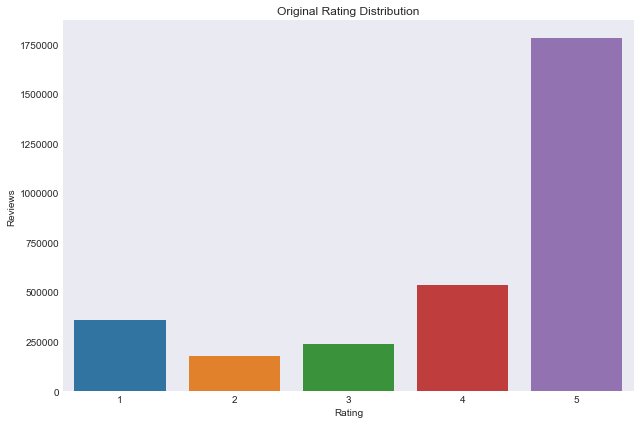

In [10]:
# check the rating distribution
plt.figure(figsize=((9, 6)))
hist_ax = sns.countplot(x='star_rating', data=df)
hist_ax.set(xlabel='Rating', ylabel='Reviews')
hist_ax.set(title='Original Rating Distribution')
plt.tight_layout()

if not os.path.isfile('figures/ratings_distributions.jpg'):
    plt.savefig('figures/ratings_distributions.jpg')

In [20]:
%%time

to_plot = ['review_lengths', 'review_words', 'review_unique_words']
review_lengths = df['review_body'].apply(lambda x: len(x)) # count the number of characters
review_words = df['review_body'].apply(lambda x: len(x.split(' '))) # count then number of words
review_unique_words = df['review_body'].apply(lambda x: len(set(x.split(' ')))) # count the number of unique words

review_text_lengths = pd.DataFrame({
    'review_lengths': review_lengths,
    'review_words': review_words,
    'review_unique_words': review_unique_words,
    'star_rating': df['star_rating'].copy(deep=True)
})

# display some descriptive statistics
review_text_lengths.describe().T

Wall time: 37.4 s


,count,mean,std,min,25%,50%,75%,max
review_lengths,3093869.0,375.269285,645.558257,1.0,102.0,189.0,416.0,50610.0
review_words,3093869.0,70.664756,118.613868,1.0,20.0,36.0,79.0,8543.0
review_unique_words,3093869.0,49.265280,57.229341,1.0,18.0,31.0,61.0,2201.0
star_rating,3093869.0,4.035507,1.387438,1.0,3.0,5.0,5.0,5.0


In [21]:
# optimize memory usage
review_text_lengths = review_text_lengths.apply(lambda x: pd.to_numeric(x, downcast="integer")) 
review_text_lengths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3093869 entries, 0 to 3093868
Data columns (total 4 columns):
 #   Column               Dtype
---  ------               -----
 0   review_lengths       int32
 1   review_words         int16
 2   review_unique_words  int16
 3   star_rating          int8 
dtypes: int16(2), int32(1), int8(1)
memory usage: 26.6 MB


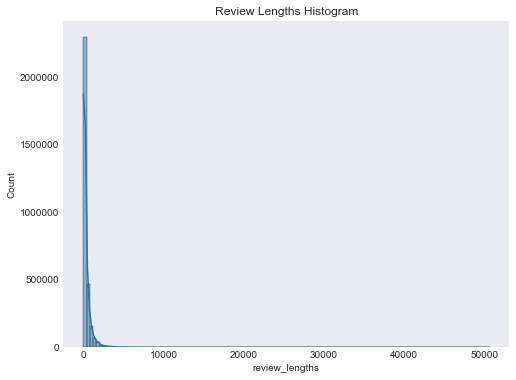

In [22]:
# identify the how long the reviews are
fig = plt.figure(figsize=(8, 6))
sns.histplot(x='review_lengths', data=review_text_lengths, kde=True, bins=125)
plt.title('Review Lengths Histogram')
plt.show()

In [23]:
# most of the reviews are short.
# removing reviews that are longer than 1500 characters (about half a page)
long_reviews_text = review_text_lengths.loc[review_text_lengths['review_lengths'] > 1.5e3]
regular_reviews_text  = review_text_lengths.loc[review_text_lengths['review_lengths'] <= 1.5e3]

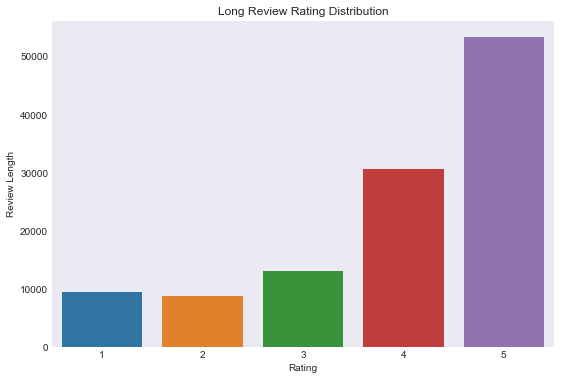

In [24]:
# check the distribution of ratings among verbous reviews
plt.figure(figsize=((9, 6)))
ax = sns.countplot(x='star_rating', data=long_reviews_text)
ax.set(xlabel='Rating', ylabel='Review Length')
ax.set(title='Long Review Rating Distribution')
plt.show()

In [25]:
long_reviews_text.describe().T

,count,mean,std,min,25%,50%,75%,max
review_lengths,115558.0,2715.984493,1819.914129,1501.0,1739.0,2117.0,3016.0,50610.0
review_words,115558.0,501.819943,326.455428,24.0,325.0,395.0,560.0,8543.0
review_unique_words,115558.0,256.837000,102.659468,2.0,194.0,225.0,285.0,2201.0
star_rating,115558.0,3.952085,1.270238,1.0,3.0,4.0,5.0,5.0


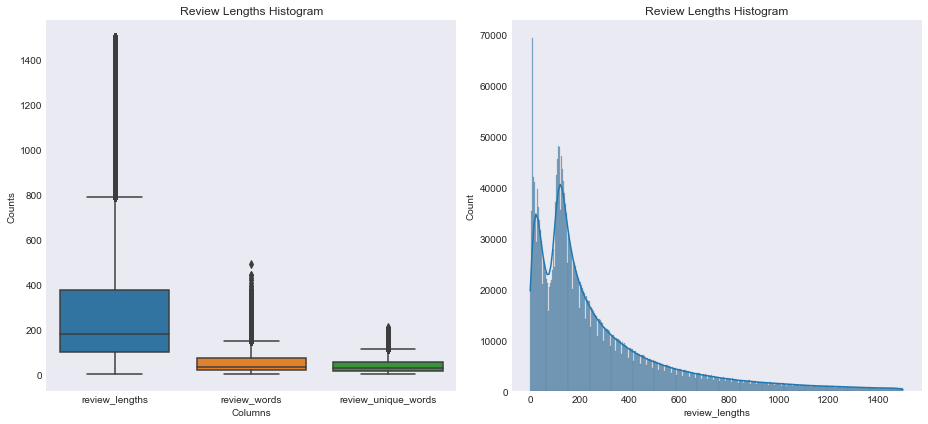

In [26]:
# check the distribution of ratings among remaining reviews
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

# boxplots
columns_to_melt = ['review_lengths', 'review_words', 'review_unique_words']
sns.boxplot(x="variable", y="value", data=pd.melt(regular_reviews_text[columns_to_melt]), ax=ax[0])
ax[0].set_title('Review Lengths Histogram')
ax[0].set_xlabel('Columns')
ax[0].set_ylabel('Counts')

# histogram
sns.histplot(x='review_lengths', data=regular_reviews_text, kde=True, ax=ax[1])
ax[1].set_title('Review Lengths Histogram')

plt.tight_layout()

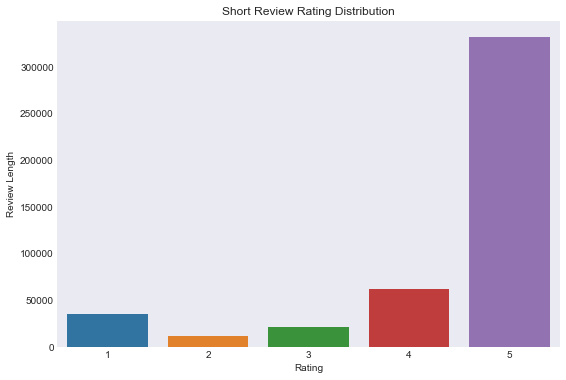

In [32]:
really_short_reviews = review_text_lengths.loc[review_text_lengths['review_lengths'] <= 50]
plt.figure(figsize=((9, 6)))
ax = sns.countplot(x='star_rating', data=really_short_reviews)
ax.set(xlabel='Rating', ylabel='Review Length')
ax.set(title='Short Review Rating Distribution')
plt.show()

* __Null Hypothesis__: People that write short reviews leave ratings at random. Equal probability for ratings 1 - 5.
* __Hypothesis__: People that write short reviews do not leave ratings at random 

alpha = 0.05 (5%)

In [46]:
a['review_lengths'].values

array([ 35125,  12249,  21229,  62775, 332430], dtype=int64)

In [47]:
d = pd.DataFrame()
a = really_short_reviews[['review_lengths', 'star_rating']].groupby(['star_rating']).agg('count')
a = a['review_lengths'].values
d['test'] = a

In [48]:
d

,test
0,35125
1,12249
2,21229
3,62775
4,332430


In [51]:
## create contingency table

# separate the population that wrote reviews longer than 50 charachters
rest_lengths_reviews = review_text_lengths.loc[review_text_lengths['review_lengths'] > 50]

short_lengths = really_short_reviews[['review_lengths', 'star_rating']].groupby(['star_rating']).agg('count')
regular_lengths = rest_lengths_reviews[['review_lengths', 'star_rating']].groupby(['star_rating']).agg('count')

contingency_table = pd.DataFrame()
contingency_table['short_reviews'] = short_lengths['review_lengths'].to_numpy()
contingency_table['regular_reviews'] = regular_lengths['review_lengths'].to_numpy()

contingency_table.T

,0,1,2,3,4
short_reviews,35125,12249,21229,62775,332430
regular_reviews,322995,166931,217358,474046,1448731


In [52]:
# chi-squared test
from scipy.stats import chi2_contingency
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(contingency_table.T.values)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    # interpret p-value

alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))

if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=4
[[  53686.475077     26861.22697503   35767.04743995   80475.89421789
   267017.35629013]
 [ 304433.524923    152318.77302497  202819.95256005  456345.10578211
  1514143.64370987]]
probability=0.950, critical=9.488, stat=47281.406
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


KeyboardInterrupt: 

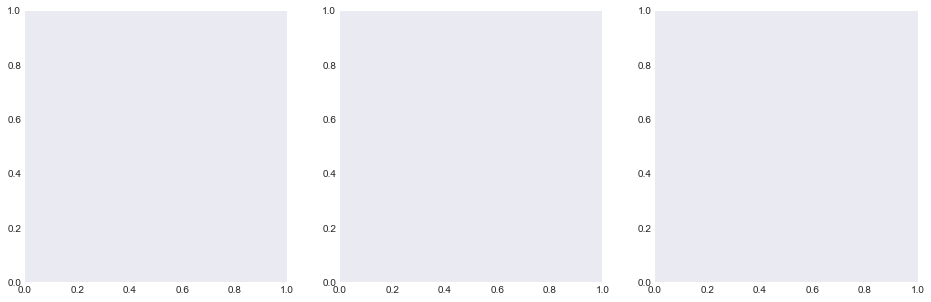

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, column in enumerate(to_plot):
    sns.barplot(x="star_rating", y=column, data=review_text_lengths, ax=ax[i])

fig.subplots_adjust(top=.9)
fig.suptitle('Stats by Team')
plt.show()

,review_lengths,review_words,review_unique_words,star_rating
review_lengths,1.000000,0.997449,0.953027,-0.050635
review_words,0.997449,1.000000,0.957815,-0.053185
review_unique_words,0.953027,0.957815,1.000000,-0.074715
star_rating,-0.050635,-0.053185,-0.074715,1.000000


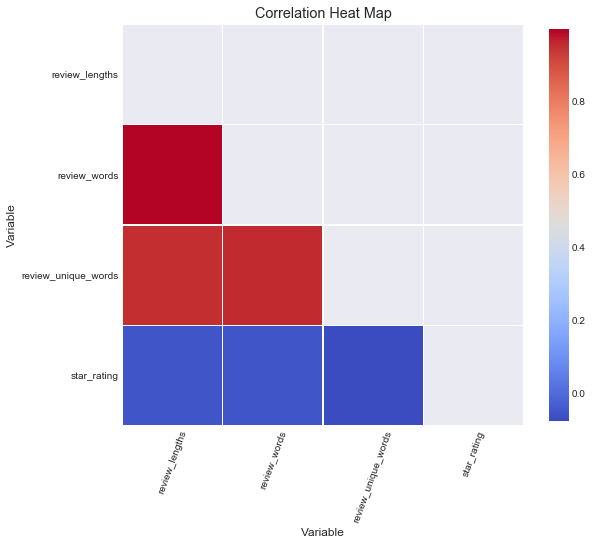

In [136]:
def plot_correlations(df: pd.DataFrame, xrot: Optional[int] = 70, yrot: Optional[int] = 0, 
                       label: Optional[str] = 'Variable'):
    '''
    This function accepts a pandas dataframe and returns a column heatmap
    inputs:
        df:
        xrot:
        yrot:
        label:
    '''
    
    correlations = df.corr()
    
    # exclude duplicate correlations by masking uper right values
    mask = np.zeros_like(correlations, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # set background color / chart style
    sns.set_style(style='dark')
    fig, ax = plt.subplots(figsize=(9, 9))

    # add colormap from blue to red
    cmap = sns.color_palette('coolwarm', as_cmap=True)
    # add titles
    plt.title("Correlation Heat Map")

    # draw correlations
    sns.heatmap(correlations, mask=mask, cmap=cmap,
                square=True,
                linewidth=.5, cbar_kws={"shrink": .8}, ax=ax)
    
    plt.xlabel(label)
    plt.ylabel(label)
    plt.xticks(rotation=xrot)
    plt.yticks(rotation=yrot)
    return correlations

plot_correlations(review_text_lengths)

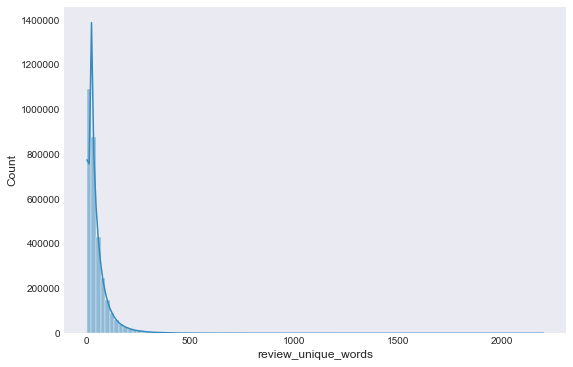

In [94]:
    
    
plt.figure(figsize=((9, 6)))
lengths_ax = sns.histplot(x='review_unique_words', data=review_text_lengths, bins=100, kde=True)
# hist_ax.set(xlabel='Rating', ylabel='Reviews')
# hist_ax.set(title='Original Rating Distribution')
# plt.tight_layout()

# if not os.path.isfile('figures/ratings_distributions.jpg'):
#     plt.savefig('figures/ratings_distributions.jpg')

In [50]:
df['review_body']

0                                              As described.
1                                   It works as advertising.
2                                                Works pissa
3                                       Did not work at all.
4          Works well. Bass is somewhat lacking but is pr...
                                 ...                        
3093864    Diamond's RIO is the current, silicon-state ni...
3093865    The RIO rocks! It is so great that Diamond Mul...
3093866    I have listened to practically every boombox a...
3093867    compared to my old discman this one is really ...
3093868    I love Christmas videos and music, but I usual...
Name: review_body, Length: 3093869, dtype: object

In [55]:
review_lengths

review_body    3093869
dtype: int64

In [57]:
len('string')

6

In [85]:
review_text_lengths

,review_lengths,review_words,review_unique_words
0,13,2,2
1,24,4,4
2,11,2,2
3,20,5,5
4,83,14,13
...,...,...,...
3093864,929,141,96
3093865,507,93,73
3093866,617,110,80
3093867,113,21,17


In [87]:
import nltk
from nltk.corpus import stopwords

In [91]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each